<h1 align=center>Indo mais fundo – A mecânica do TensorFlow</h1>
<p align=center><img src=https://cdn.shortpixel.ai/spai/w_912+q_+ret_img+to_webp/https://iaexpert.academy/wp-content/uploads/2021/01/26.01.png width = 500></p>

Agora que temos alguma experiência prática com treinamento de uma Rede Neural (RN) do *TensorFlow* e aprendizado de máquina, é hora de mergulhar mais fundo na biblioteca do *TensorFlow* e explorar seu rico conjunto de recursos, o que nos permitirá implementar um aprendizado profundo mais avançado modelos nas próximas etapas.

Usaremos diferentes aspectos da API do *TensorFlow* para implementar as RNs. Em particular, usaremos novamente a API *Keras*, que fornece várias camadas de abstração para tornar a implementação de arquiteturas padrão muito conveniente. O *TensorFlow* também nos permite implementar camadas RNs personalizadas, o que é muito útil em projetos orientados à pesquisa que exigem mais personalização. Mais adiante, implementaremos essa camada personalizada.

Para ilustrar as diferentes formas de construção de modelos usando a API *Keras*, também consideraremos o problema clássico **exclusivo ou (XOR)**. Primeiramente, construiremos perceptrons multicamadas usando a classe `Sequential`. Em seguida, consideraremos outros métodos, como subclassificar `tf.keras.Model` para definir camadas personalizadas. Por fim, abordaremos o `tf.estimator`, uma API *TensorFlow* de alto nível que encapsula as etapas de aprendizado de máquina da entrada bruta à previsão.

### Como criar um gráfico no *TensorFlow* v1.x
Na versão anterior da API de baixo nível do *TensorFlow* (v1.x), esse gráfico precisava ser declarado explicitamente. As etapas individuais para criar, compilar e avaliar esse gráfico de computação no *TensorFlow* v1.x são as seguintes:
1. Instanciar um novo gráfico de computação vazio
2. Adicione nós (tensores e operações) ao gráfico de computação
3. Avalie (execute) o gráfico:
* Iniciar uma nova sessão
* Inicialize as variáveis ​​no gráfico
* Execute o gráfico de computação nesta sessão

Antes de darmos uma olhada na abordagem dinâmica no *TensorFlow* v2, vamos ver um exemplo simples que ilustra como criar um gráfico no *TensorFlow* v1.x para calcular $\small z = 2 \times (a-b) + c$. As variáveis $​​\small a$, $​​\small b$ e $​​\small c$ são escalares (números únicos) e definimos como constantes do *TensorFlow*. Um gráfico pode então ser criado chamando `tf.Graph()`. As variáveis, assim como os cálculos, representam os nós do gráfico, que definiremos da seguinte forma:

In [2]:
## TF v1.x style
import tensorflow as tf
g = tf.Graph()

with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a-b) + c


Neste código, primeiro definimos o gráfico `g` via `g=tf.Graph()`. Em seguida, adicionamos nós ao gráfico, `g`, usando com `g.as_default()`. No entanto, observe que, se não criarmos um gráfico explicitamente, sempre haverá um gráfico padrão ao qual variáveis ​​e cálculos serão adicionados automaticamente.

No *TensorFlow* v1.x, uma sessão é um ambiente no qual as operações e os tensores de um gráfico podem ser executados. A classe `Session` foi removida do *TensorFlow* v2; No entanto, por enquanto, ele ainda está disponível por meio do submódulo `tf.compat` para permitir a compatibilidade com o *TensorFlow* v1.x. Um objeto de sessão pode ser criado chamando `tf.compat.v1.Session()`, que pode receber um gráfico existente (no caso, `g`) como argumento, como em `Session(graph=g)`.

Após lançar um gráfico em uma sessão do *TensorFlow*, podemos executar seus nós, ou seja, avaliar seus tensores ou executar seus operadores. Avaliar cada tensor individual envolve chamar seu método `eval()` dentro da sessão atual. Ao avaliar um tensor específico no gráfico, o *TensorFlow* precisa executar todos os nós anteriores no gráfico até atingir o nó de interesse fornecido. Caso haja uma ou mais variáveis *​​placeholder*, também precisamos fornecer valores para elas através do método `run` da sessão, como veremos mais adiante.

Depois de definir o gráfico estático no trecho de código anterior, podemos executar o gráfico em uma sessão do *TensorFlow* e avaliar o tensor, `z`, da seguinte forma:

In [3]:
## TF v1.x style

with tf.compat.v1.Session(graph=g) as sess:
    print('Result: z = ', sess.run(z))

Result: z =  1


### Como migrar um gráfico para o *TensorFlow* v2

Em seguida, vamos ver como esse código pode ser migrado para o *TensorFlow* v2. O *TensorFlow* v2 usa gráficos dinâmicos (em oposição aos estáticos) por padrão (isso também é chamado de execução antecipada no *TensorFlow*), o que nos permite avaliar uma operação em tempo real. Portanto, não precisamos criar explicitamente um gráfico e uma sessão, o que torna o fluxo de trabalho de desenvolvimento muito mais conveniente:

In [4]:
## TF v2 Style
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c

tf.print('Result: z = ', z)



Result: z =  1


### Carregando dados de entrada em um modelo: estilo *TensorFlow* v1.x

Outra melhoria importante do *TensorFlow* v1.x para v2 diz respeito a como os dados podem ser carregados em nossos modelos. No *TensorFlow* v2, podemos alimentar dados diretamente na forma de variáveis *Python* ou arrays *NumPy*. No entanto, ao usar a API de baixo nível do *TensorFlow* v1.x, tivemos que criar variáveis de espaço reservado para fornecer dados de entrada a um modelo. Para o exemplo de gráfico de computação simples anterior, $\small z = 2 \times (a-b) + c$, vamos supor que `a`, `b` e `c` são os tensores de entrada de *Rank* 0. Podemos então definir três espaços reservados, que usaremos para "feed" dados para o modelo por meio de um dicionário *feed_dict*, da seguinte forma:

In [5]:
## TF-v1.x style
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c
    
with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('Result: z =', sess.run(z, feed_dict=feed_dict))

Result: z = 1


### Carregando dados de entrada em um modelo: estilo *TensorFlow* v2

No *TensorFlow* v2, tudo isso pode ser feito simplesmente definindo uma função *Python* regular com `a`, `b` e `c` como seus argumentos de entrada, por exemplo:

In [6]:
## TF-v2 style
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Agora, para realizar o cálculo, podemos simplesmente chamar essa função com objetos `Tensor` como argumentos de função. Observe que as funções do *TensorFlow*, como `add`, `subtract` e `multiply`, também nos permitem fornecer entradas de classificações mais altas na forma de um objeto *TensorFlow* `Tensor`, um array *NumPy* ou possivelmente outros objetos *Python*, como listas e tuplas. No exemplo de código a seguir, fornecemos entradas escalares (*Rank* 0), bem como entradas de *Rank* 1 e *Rank* 2, como listas:

In [7]:
tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


### Melhorando o desempenho computacional com decoradores de função

Como você viu na seção anterior, podemos escrever facilmente uma função *Python* normal e utilizar as operações do *TensorFlow*. No entanto, os cálculos por meio do modo de execução antecipada (gráfico dinâmico) não são tão eficientes quanto a execução de gráfico estático no *TensorFlow* v1.x. Assim, o *TensorFlow* v2 fornece uma ferramenta chamada **AutoGraph** que pode transformar automaticamente o código *Python* no código gráfico do *TensorFlow* para uma execução mais rápida. Além disso, o *TensorFlow* fornece um mecanismo simples para compilar uma função *Python* normal em um gráfico estático do *TensorFlow* para tornar os cálculos mais eficientes.

Para ver como isso funciona na prática, vamos trabalhar com nossa função `compute_z` anterior e anotá-la para compilação de gráfico usando o decorador `@tf.function`:

In [8]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Observe que podemos usar e chamar essa função da mesma maneira que antes, mas agora o *TensorFlow* construirá um gráfico estático com base nos argumentos de entrada. *Python* suporta tipagem dinâmica e polimorfismo, então podemos definir uma função como `def f(a, b): return a+b` e chame-a usando entradas de *inteiro*, *float*, *list* ou *string* (lembre-se de que `a+b` é um valor válido operação para listas e *strings*). Embora os gráficos do *TensorFlow* exijam tipos e formas estáticos, o `tf.function` oferece suporte a esse recurso de digitação dinâmica. Por exemplo, vamos chamar esta função com as seguintes entradas:

In [9]:
tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


Veja que foi produzido as mesmas saídas de antes. Aqui, o *TensorFlow* usa um mecanismo de rastreamento para construir um gráfico com base nos argumentos de entrada. Para esse mecanismo de rastreamento, o *TensorFlow* gera uma tupla de chaves com base nas assinaturas de entrada fornecidas para chamar a função. As chaves geradas são as seguintes:

* Para argumentos `tf.Tensor`, a chave é baseada em seus *shapes* e *dtypes*.
* Para tipos *Python*, como listas, seu `id()` é usado para gerar chaves de cache.
* Para valores primitivos do *Python*, as chaves de cache são baseadas nos valores de entrada.

Ao chamar essa função decorada, o *TensorFlow* verificará se um gráfico com a chave correspondente já foi gerado. Se esse gráfico não existir, o *TensorFlow* gerará um novo gráfico e armazenará a nova chave. Por outro lado, se quisermos limitar a forma como uma função pode ser chamada, podemos especificar sua assinatura de entrada por meio de uma tupla de objetos `tf.TensorSpec` ao definir a função. Por exemplo, vamos redefinir a função anterior, `compute_z`, e especificar que apenas tensores de rank 1 do tipo `tf.int32` são permitidos:

In [10]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

Agora, podemos chamar esta função usando tensores de rank 1 (ou listas que podem ser convertidas em tensores de rank 1):

In [13]:
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 1 Inputs:', compute_z([1, 2], [2, 4], [3, 6]))

Rank 1 Inputs: [1]
Rank 1 Inputs: [1 2]


No entanto, chamar essa função usando tensores com classificações diferentes de 1 resultará em um erro, pois a classificação não corresponderá à assinatura de entrada especificada, conforme a seguir:

In [14]:
tf.print('Rank 0 Inputs:', compute_z(1, 2, 3))

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    1,
    2,
    3)
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).

In [15]:
tf.print('Rank 2 Inputs:', compute_z([[1], [2]], [[2], [4]], [[3], [6]]))

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    [[1], [2]],
    [[2], [4]],
    [[3], [6]])
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).

### Objetos variáveis do *TensorFlow* para armazenar e atualizar os parâmetros do modelo

No contexto do *TensorFlow*, uma `Variable` é um objeto Tensor especial que nos permite armazenar e atualizar os parâmetros de nossos modelos durante o treinamento. Um `Variable` pode ser criada apenas chamando a classe `tf.Variable` em valores iniciais especificados pelo usuário. No código a seguir, vamos gerar objetos `Variable` do tipo `float32`, `int32`, `bool` e `string`:

In [16]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3])>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


Observe que sempre temos que fornecer os valores iniciais ao criar um `Variable`. As variáveis têm um atributo chamado `treinable`, que, por padrão, é definido como `True`. APIs de nível superior, como *Keras*, usarão esse atributo para gerenciar as variáveis treináveis e não treináveis. Você pode definir um `Variable` não treinável da seguinte forma:

In [17]:
w = tf.Variable([1,2,3], trainable=False)

print(w.trainable)

False


Os valores de um `Variable` podem ser modificados de forma eficiente executando algumas operações como `.assign()`, `.assign_add()` e métodos relacionados. Vejamos alguns exemplos:

In [18]:
print(w.assign([3,1,4], read_value=True))

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4])>


In [19]:
w.assign_add([2,-1,2], read_value=False)

print(w.value())

tf.Tensor([5 0 6], shape=(3,), dtype=int32)


Quando o argumento `read_value` estiver definido como `True` (que também é o padrão), essas operações retornarão automaticamente os novos valores após atualizar os valores atuais da `Variable`. Definir o `read_value` como `False` suprimirá o retorno automático do valor atualizado (mas a `Variable` ainda será atualizada no local). Chamar `w.value()` retornará os valores em um formato de tensor. Observe que não podemos alterar a forma ou o tipo da `Variable` durante a atribuição.

Você deve se lembrar de que, para modelos de Rede Neural, é necessário inicializar os parâmetros do modelo com pesos aleatórios para quebrar a simetria durante a retropropagação - caso contrário, uma RN multicamada não seria mais útil do que uma RN de camada única, como regressão logística. Ao criar uma variável do *TensorFlow*, também podemos usar um esquema de inicialização aleatório. O *TensorFlow* pode gerar números aleatórios com base em várias distribuições via `tf.random`.

No exemplo a seguir, veremos alguns métodos de inicialização padrão que também estão disponíveis no *Keras*. Então, vamos ver como podemos criar uma `Variable` com inicialização *Glorot*, que é um esquema clássico de inicialização aleatória que foi proposto por Xavier Glorot e Yoshua Bengio. Para isso, criamos um operador chamado `init` como objeto da classe `GlorotNormal`. Então, chamamos esse operador e fornecemos a forma desejada do tensor de saída:

In [20]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[-0.722795904 1.01456821 0.251808226]


Agora, podemos usar este operador para inicializar uma `Variable` de formato 2 × 3 :

In [21]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


Agora, para colocar isso no contexto de um caso de uso mais prático, vamos ver como podemos definir uma `Variable` dentro da classe base `tf.Module`. Vamos definir duas variáveis: uma treinável e uma não treinável:

In [22]:
class MyModule (tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2,3)),
                                    trainable=True)
        self.w2 = tf.Variable(init(shape=(1,2)),
                                trainable = False)

m = MyModule()

print('All module variables:', [v.shape for v in m.variables])

print('Trainable variable:  ', [v.shape for v in m.trainable_variables])



All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable:   [TensorShape([2, 3])]


Como você pode ver neste exemplo de código, a subclasse da classe `tf.Module` nos dá acesso direto a todas as variáveis definidas em um determinado objeto (aqui, uma instância de nossa classe `MyModule` personalizada) por meio do atributo `.variables`.

Finalmente, vamos ver como usar variáveis dentro de uma função decorada com `tf.function`. Quando definimos uma `Variable` do TensorFlow dentro de uma função normal (não decorada), podemos esperar que uma nova `Variable` seja criada e inicializada toda vez que a função for chamada. No entanto, `tf.function` tentará reutilizar a `Variable` com base no rastreamento e na criação do gráfico. Portanto, o *TensorFlow* não permite a criação de uma `Variable` dentro de uma função decorada e, como resultado, o código a seguir gerará um erro:

In [25]:
@tf.function
def f(x):
    w = tf.Variable([1,2,3])

f([1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.

Uma maneira de evitar esse problema é definir a variável fora da função decorada e usá-la dentro da função:

In [28]:
w = tf.Variable(tf.random.uniform((3, 3)))

@ tf.function
def compute_z(x):
    return tf.matmul(w , x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)

tf.print(compute_z(x))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[4.68231201]
 [3.49924636]
 [2.97944832]]


### Computação de gradientes via diferenciação automática e *GradientTape*

Como você já sabe, otimizar RNs requer calcular os gradientes do custo em relação aos pesos da Rn. Isso é necessário para algoritmos de otimização, como gradiente descendente estocástico (SGD). Além disso, os gradientes têm outras aplicações, como diagnosticar a rede para descobrir por que um modelo de RN está fazendo uma previsão específica para um exemplo de teste. Portanto, nesta seção, abordaremos como calcular gradientes de uma computação em relação a algumas variáveis.

### Calculando os gradientes da perda em relação às variáveis ​​treináveis

O *TensorFlow* oferece suporte à **diferenciação automática**, que pode ser considerada uma implementação da regra da cadeia para calcular gradientes de funções aninhadas. Quando definimos uma série de operações que resultam em alguma saída ou mesmo tensores intermediários, o *TensorFlow* fornece um contexto para calcular gradientes desses tensores calculados em relação a seus nós dependentes no gráfico de computação. Para calcular esses gradientes, temos que "gravar" os cálculos via `tf.GradientTape`.

Vamos trabalhar com um exemplo simples onde vamos calcular $\small z = wx + b$ e definir a perda como a perda ao quadrado entre o alvo e a previsão, $\small Loss = (y - z)^2$. No caso mais geral, onde podemos ter várias previsões e metas, calcule a perda como a soma do erro ao quadrado, $\small Loss = \sum_i(y_i - z_i)^2$. Para implementar esse cálculo no *TensorFlow*, vamos definir os parâmetros do modelo, $\small w$ e $\small b$, como variáveis, e as entradas $\small x$ e $\small y$, como tensores. Colocaremos o cálculo de $\small z$ e a perda dentro do contexto `tf.GradientTape`:

In [29]:
import tensorflow as tf

w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [30]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw)

dL/dw :  -0.559999764


Ao calcular o valor $\small z$, podemos pensar nas operações necessárias, que gravamos na "gradient tape", como uma passagem para frente em uma RN. Usamos `tape.gradient` para calcular $\small \dfrac{\partial Loss}{\partial w}$ . Como este é um exemplo muito simples, podemos obter as derivadas, $\small \dfrac {\partial Loss}{\partial w} = 2x(wx + b - y)$, simbolicamente para verificar que os gradientes calculados obtivemos no exemplo de código anterior:

In [31]:
# verifying the computed gradient
tf.print(2*x*(w*x  + b - y))

[-0.559999764]


### Computação de gradientes em relação a tensores não treináveis

`tf.GradientTape` suporta automaticamente os gradientes para variáveis treináveis. No entanto, para variáveis não treináveis e outros objetos `Tensor`, precisamos adicionar uma modificação adicional ao `GradientTape` chamada `tape.watch()` para monitorá-los também. Por exemplo, se estivermos interessados em calcular $\small \dfrac {\partial Loss}{\partial x}$ , o código será o seguinte:

In [32]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


In [33]:
# verifying the computed gradient
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### Mantendo recursos para vários cálculos de gradiente
Quando monitoramos os cálculos no contexto de`tf.GradientTape`, por padrão, a fita manterá os recursos apenas para um único cálculo de gradiente. Por exemplo, após chamar `tape.gradient()` uma vez, os recursos serão liberados e a fita será limpa. Portanto, se quisermos calcular mais de um gradiente, por exemplo, ambos $\small \dfrac {\partial Loss}{\partial w}$ e $\small \dfrac {\partial Loss}{\partial b}$ , precisamos tornar a fita persistente:

In [34]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


In [35]:
tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


No entanto, lembre-se de que isso só é necessário quando queremos calcular mais de um gradiente, pois gravar e manter a fita gradiente é menos eficiente em termos de memória em comparação com liberar a memória após um único cálculo de gradiente. É também por isso que a configuração padrão é `persistent=False`.

Finalmente, se estivermos computando gradientes de um termo de perda em relação aos parâmetros de um modelo, podemos definir um otimizador e aplicar os gradientes para otimizar os parâmetros do modelo usando a API `tf.keras`, como segue:

In [36]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('Updated w:', w)
tf.print('Updated bias:', b)

Updated w: 1.0056
Updated bias: 0.504


Você deve se lembrar que o peso inicial e a unidade de viés eram $\small w$ = 1,0 e $\small b$ = 0,5, e a aplicação dos gradientes da perda em relação aos parâmetros do modelo mudou os parâmetros do modelo para $\small w$ = 1,0056 e $\small b$ = 0,504.

### Simplificando implementações de arquiteturas comuns por meio da API *Keras*
Você já viu alguns exemplos de construção de um modelo de RN *feedforward* (por exemplo, um *perceptron* multicamadas) e definição de uma sequência de camadas usando a classe `Sequential` do *Keras*. Antes de examinarmos diferentes abordagens para configurar essas camadas, vamos recapitular brevemente as etapas básicas construindo um modelo com duas camadas densamente (totalmente) conectadas:

In [37]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

# late variable creation

model.build(input_shape=(None,4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


Especificamos a forma de entrada com `model.build()`, instanciando as variáveis após definir o modelo para essa forma específica. O número de parâmetros de cada camada é exibido: $\small 16 × 4 + 16 = 80$ para a primeira camada e $\small 16 × 32 + 32 = 544$ para a segunda camada. Depois que as variáveis (ou parâmetros do modelo) são criadas, podemos acessar as variáveis treináveis e não treináveis da seguinte forma:

In [39]:
# Apresentado as variáveis do modelo.
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


Nesse caso, cada camada possui uma matriz de pesos chamada `kernel`, bem como um vetor de polarização.

Em seguida, vamos configurar essas camadas, por exemplo, aplicando diferentes funções de ativação, inicializadores de variáveis ou métodos de regularização aos parâmetros. Uma lista abrangente e completa de opções disponíveis para essas categorias pode ser encontrada na documentação oficial:

* Escolhendo funções de ativação via `tf.keras.activations`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/ativactions
* Inicializando os parâmetros da camada via `tf.keras.initializers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers
* Aplicando regularização aos parâmetros da camada (para evitar *overfitting*) via `tf.keras.regularizers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers

No exemplo de código a seguir, configuraremos a primeira camada especificando inicializadores para as variáveis kernel e bias. Em seguida, configuraremos a segunda camada especificando um regularizador L1 para o kernel (matriz de peso):

In [45]:
model = tf.keras.Sequential()
model.add(
        tf.keras.layers.Dense(
            units=16,
            activation = tf.keras.activations.relu,
            kernel_initializer = tf.keras.initializers.GlorotUniform(),
            bias_initializer = tf.keras.initializers.Constant(2.0)
        )
)

model.add(
    tf.keras.layers.Dense(
        units = 32,
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    )
)

Além disso, além de configurar as camadas individuais, também podemos configurar o modelo ao compilá-lo. Podemos especificar o tipo de otimizador e a função de perda para treinamento, bem como quais métricas usar para relatar o desempenho nos conjuntos de dados de treinamento, validação e teste. Novamente, uma lista abrangente de todas as opções disponíveis pode ser encontrada na documentação oficial:
* Otimizadores via tf.keras.optimizers: https://www.tensorflow.org/versões/r2.0/api_docs/python/tf/keras/optimizers
* Funções de perda via tf.keras.losses: https://www.tensorflow.org/versões/r2.0/api_docs/python/tf/keras/losses
* Métricas de desempenho via tf.keras.metrics: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics

> ##### Escolhendo uma função de perda
> Em relação às escolhas de algoritmos de otimização, *SGD* e *Adam* são os métodos mais utilizados. A escolha da função de perda depende da tarefa; por exemplo, você pode usar a perda de erro quadrático médio para um problema de regressão. A família de funções de perda de entropia cruzada fornece as opções possíveis para tarefas de classificação.
> 
> Além disso, você pode usar as técnicas que aprendeu antes (por exemplo, técnicas para avaliação de modelos) combinadas com as métricas apropriadas para o problema. Por exemplo, *precision* e *recall*, *accuracy*, área sob a curva (AUC) e pontuações de falso negativo e falso positivo são métricas apropriadas para avaliar modelos de classificação.

Neste exemplo, compilaremos o modelo usando o otimizador *SGD*, perda de entropia cruzada para classificação binária e uma lista específica de métricas, incluindo *precision* e *recall*, *accuracy*:

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()]
)

Quando treinamos este modelo chamando `model.fit(...)`, será retornado o histórico da perda e as métricas especificadas para avaliar o desempenho do treinamento e validação (se for usado um conjunto de dados de validação), que pode ser usado para diagnosticar o comportamento de aprendizagem.

A seguir, veremos um exemplo mais prático: resolvendo o problema clássico de classificação $\small XOR$ usando a API *Keras*. Primeiro, usaremos a classe `tf.keras.Sequential()` para construir o modelo. Ao longo do caminho, você também aprenderá sobre a capacidade de um modelo para lidar com limites de decisão não lineares. Em seguida, abordaremos outras formas de construir um modelo que nos dará mais flexibilidade e controle sobre as camadas da rede.

### Resolvendo um problema de classificação XOR
O problema de classificação $\small XOR$ é um problema clássico para analisar a capacidade de um modelo em capturar o limite de decisão não linear entre duas classes. Geramos um conjunto de dados fictício de 200 exemplos de treinamento com dois recursos ($\small x_0$, $\small x_1$) extraídos de uma distribuição uniforme entre [−1,1) . Em seguida, atribuímos o rótulo de verdade do terreno para o exemplo de treinamento $\small i$ de acordo com a seguinte regra:

$$
y^{(i)} =
\begin{cases}
0 \quad \text{if $x_0^{(i)} \times x_1^{(i)}<$0}\\
1 \quad \text{otherwise}
\end{cases}
$$

Usaremos metade dos dados (100 exemplos de treinamento) para treinamento e a metade restante para validação. O código para gerar os dados e dividi-los nos conjuntos de dados de treinamento e validação é o seguinte:


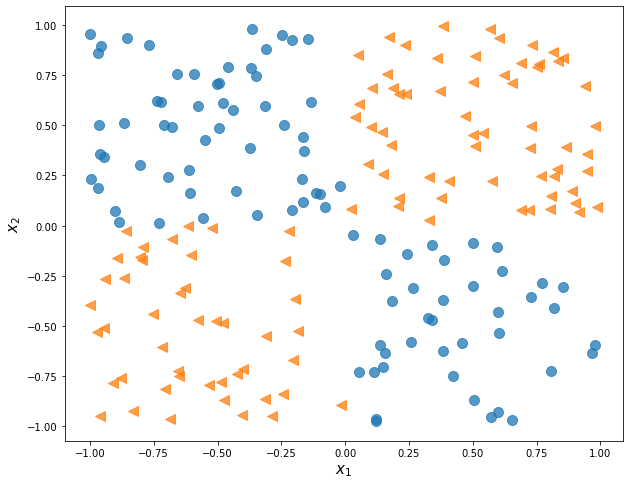

In [49]:
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(10, 8))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

Na subseção anterior, abordamos as ferramentas essenciais necessárias para implementar um classificador no Tenso*rFlow. Agora precisamos decidir qual arquitetura devemos escolher para essa tarefa e conjunto de dados. Como regra geral, quanto mais camadas tivermos, e quanto mais neurônios tivermos em cada camada, maior será a capacidade do modelo. Aqui, a capacidade do modelo pode ser pensada como uma medida de quão prontamente o modelo pode aproximar funções complexas. Embora ter mais parâmetros signifique que a rede pode ajustar funções mais complexas, modelos maiores geralmente são mais difíceis de treinar (e propensos a *overfitting*).

Na prática, é sempre uma boa ideia começar com um modelo simples como linha de base, por exemplo, uma RN de camada única como regressão logística:

In [50]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                input_shape=(2,),
                activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
